In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.impute import SimpleImputer 
from xgboost import XGBClassifier

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3354 entries, 59871 to 58034
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FundingSource   3354 non-null   object 
 1   LTV             3354 non-null   float64
 2   State           3354 non-null   object 
 3   LoanProcessor   3354 non-null   object 
 4   LoanOfficer     3354 non-null   object 
 5   LoanAmount      3354 non-null   float64
 6   AppraisedValue  3354 non-null   float64
 7   Closed          3354 non-null   int64  
 8   TimeWindow      3354 non-null   float64
dtypes: float64(4), int64(1), object(4)
memory usage: 262.0+ KB


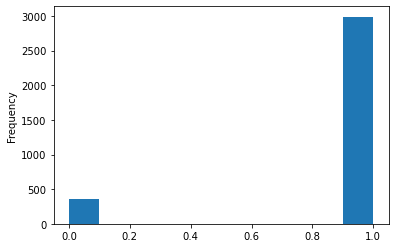

In [46]:
# load data
hmmtc = pd.read_csv('test2-7-2.csv')
hmmtc[['LoanNo.','Closed']] = hmmtc[['LoanNo.','Closed']].astype(int)
hmmtc = hmmtc.set_index('LoanNo.')
hmmtc.info()

hmmtc['Closed'].plot.hist()

In [47]:
hmmtc

,FundingSource,LTV,State,LoanProcessor,LoanOfficer,LoanAmount,AppraisedValue,Closed,TimeWindow
LoanNo.,,,,,,,,,
59871,First Bank,90.0,CO,JessicaPurtee,SusanAubin,291105.0,365000.0,1,30.000000
59919,MMRC,90.0,CA,CJ,TravisMullen,634500.0,980000.0,1,10.299909
59936,MMRC,74.0,AZ,Hayley,ChrisAepli,213300.0,287500.0,1,10.299909
59942,TBD_FS,90.0,AZ,Hayley,HerbBourdeaux,351990.0,301250.0,1,0.000000
59915,A Bonds,75.0,AZ,JessicaPurtee,MarkSteinbeck,223650.0,315000.0,1,16.000000
...,...,...,...,...,...,...,...,...,...
58102,PortAB,75.0,TX,CJ,Max,114750.0,265000.0,1,10.000000
57993,TBD_FS,81.0,CO,CJ,Max,237750.0,317000.0,1,1.000000
57563,PortAB,70.0,TX,Sabrina,Max,106508.0,185000.0,1,10.299909


In [ ]:
# count
count1, count0 = hmmtc['Closed'].value_counts()
#count1, count0
closed = hmmtc[hmmtc.Closed==1]
withdraw = hmmtc[hmmtc.Closed==0]

# resample
overwd = withdraw.sample(count1, replace=True)
oversample = pd.concat([closed,overwd], axis=0)
oversample['Closed'].plot.hist()

In [49]:
y=oversample.Closed
X=oversample.drop(['Closed'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=25)

In [50]:
hmmtc.columns

Index(['FundingSource', 'LTV', 'State', 'LoanProcessor', 'LoanOfficer',
       'LoanAmount', 'AppraisedValue', 'Closed', 'TimeWindow'],
      dtype='object')

In [51]:
# Convert the Dataframe to a lists of lists
X_train = X_train.values.tolist()
y_train = y_train.values.tolist()
X_test = X_test.values.tolist()
y_test = y_test.values.tolist()


In [52]:
columns = ('Funding Source', 
           'LTV', 
           'State', 
           'Loan Processor', 
           'Loan Officer',
           'Loan Amount', 
           'Appraised Value',  
           'Time Window')
cate_col = ('Funding Source', 
           'State', 
           'Loan Processor', 
           'Loan Officer')

In [53]:
cate_pipe = []

for i, col in enumerate(columns):
    if col in cate_col:
        scores = []
        # Build the scores array: scores = [0, 1, 0, 0, 0, 0, 0, 0, 0]
        #    extract col2
        for j in range(len(columns)):
            if i==j: #extract categorical columns
                scores.append(1)
            else:
                scores.append(0)
        
        skb = SelectKBest(k=1)
        skb.scores_ = scores
        # Convert the categorical column to a numerical value
        lbn = LabelBinarizer()
        r = skb.transform(X_train)
        lbn.fit(r)
        # Create the pipeline to extract the categorical feature
        cate_pipe.append((
            'categorical-{}'.format(i), Pipeline([
                ('skb-{}'.format(i), skb),
                ('lbn-{}'.format(i), lbn)
            ])))
        
# Create pipeline to extract the numerical features
skb = SelectKBest(k=4)
# From columns use the features that are numerical
skb.scores_ = [0,1,0,0,0,1,1,1]
cate_pipe.append(('numerical', skb))

cate_pipe        

[('categorical-0',
  Pipeline(memory=None,
       steps=[('skb-0', SelectKBest(k=1, score_func=<function f_classif at 0x7f7430ca5320>)), ('lbn-0', LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False))])),
 ('categorical-2',
  Pipeline(memory=None,
       steps=[('skb-2', SelectKBest(k=1, score_func=<function f_classif at 0x7f7430ca5320>)), ('lbn-2', LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False))])),
 ('categorical-3',
  Pipeline(memory=None,
       steps=[('skb-3', SelectKBest(k=1, score_func=<function f_classif at 0x7f7430ca5320>)), ('lbn-3', LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False))])),
 ('categorical-4',
  Pipeline(memory=None,
       steps=[('skb-4', SelectKBest(k=1, score_func=<function f_classif at 0x7f7430ca5320>)), ('lbn-4', LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False))])),
 ('numerical',
  SelectKBest(k=4, score_func=<function f_classif at 0x7f7430ca5320>))]

In [54]:
# Combine all the features using FeatureUnion
preprocess = FeatureUnion(cate_pipe)

# Create the classifier
classifier = XGBClassifier(n_estimators=300,max_depth=5,learning_rate=0.3,reg_alpha=0.1,reg_lambda=1)

# Transform the features and fit them to the classifier
classifier.fit(preprocess.transform(X_train), y_train)

# Create the overall model as a single pipeline
pipeline = Pipeline([
    ('union', preprocess),
    ('classifier', classifier)
])

#### (not being used at present)

import firebase_admin
from firebase_admin import credentials

cred = credentials.Certificate("cred.json")
firebase_admin.initialize_app(cred)

from sklearn.externals import joblib
from firebase_admin import storage

joblib.dump(pipeline, 'model.joblib') # dump model into joblib file
bucket = storage.bucket(name='elphi-da-staging') # save it to firebase storage bucket; name: save path - bucket path

b = bucket.blob('model.joblib')
b.upload_from_filename('model.joblib')
print('model uploaded!')

## BigQuery

#### Before running this part, run the following codes in Google cloud console to get the latest data: 
gcloud firestore export gs://mmtc-staging.appspot.com --collection-ids=analytics 
 
#### Then you will get **outputUriPrefix** like this:
gs://mmtc-staging.appspot.com/2020-07-31T17:25:04_27449

In [56]:
from google.cloud import bigquery
from google.oauth2 import service_account
from googleapiclient.discovery import build
from datetime import date
import os
from flask import Flask, request
#!pip install google-api-python-client

##### 

def create_table(outputUriPrefix):
    """create table in bigquery"""
    
    global client
    global today
    
    client = bigquery.Client(project='mmtc-staging')
    dataset_id = 'analytics'


    source_uris = outputUriPrefix + "/all_namespaces/kind_analytics/all_namespaces_kind_analytics.export_metadata"

    # Configure the external data source
    dataset_ref = client.dataset(dataset_id)

    today = date.today().strftime("%m%d%y")
    table_id = "latest_dataset_" + today
    #print(table_id)

    table = bigquery.Table(dataset_ref.table(table_id))
    external_config = bigquery.external_config.ExternalConfig("DATASTORE_BACKUP")
    external_config.source_uris = [source_uris]
    table.external_data_configuration = external_config

    # Create a permanent table linked to the GCS file
    table = client.create_table(table)

    
##### run upper code in GCP console and replace the following path with the latest one
outputUriPrefix = "gs://mmtc-staging.appspot.com/2020-07-31T17:25:04_27449"
##### create latest table
create_table(outputUriPrefix)

In [57]:
def create_table(outputUriPrefix):
    """create table in bigquery"""
    
    global client
    global today
    global table_id
    
    client = bigquery.Client(project='mmtc-staging')
    dataset_id = 'analytics'


    source_uris = outputUriPrefix + "/all_namespaces/kind_analytics/all_namespaces_kind_analytics.export_metadata"

    # Configure the external data source
    dataset_ref = client.dataset(dataset_id)

    today = date.today().strftime("%m%d%y")
    table_id = "latest_dataset_" + today
    #print(table_id)

    table = bigquery.Table(dataset_ref.table(table_id))
    job_config = bigquery.LoadJobConfig()
    job_config.source_format = "DATASTORE_BACKUP"
    job_config.write_disposition = "WRITE_TRUNCATE"
    
    load_job = client.load_table_from_uri(source_uris,
                                          dataset_ref.table(table_id),
                                          job_config=job_config)

    
# run upper code in GCP console and replace the following path with the latest one
outputUriPrefix = "gs://mmtc-staging.appspot.com/2020-07-31T17:25:04_27449"
# create latest table
create_table(outputUriPrefix)

In [58]:
table = client.get_table("mmtc-staging.analytics."+table_id)  # Make an API request.

original_schema = table.schema
new_schema = original_schema[:]  # Creates a copy of the schema.
#new_schema.append(bigquery.SchemaField("FundingSource", "STRING"))
new_schema.append(bigquery.SchemaField("AppraisedValue", "FLOAT"))

table.schema = new_schema
table = client.update_table(table, ["schema"])  # Make an API request.

In [59]:
# perform a query
query = """
SELECT ID, FundingSource, LTV, State, LoanProcessor,LoanOfficer, LoanAmount, 
       IF((ABS(TimeWindow)>1000),0,TimeWindow) AS TimeWindow, 
       AppraisedValue
FROM  
  (SELECT ID, FundingSource, LTV, State, LoanProcessor,LoanOfficer, LoanAmount, AppraisedValue, 
          (DATETIME_DIFF(parse_datetime('%m/%d/%Y',CloseDate), parse_datetime('%m/%d/%Y',SignedDate), DAY)) AS TimeWindow    
   FROM
        (SELECT  
            LoanOriginationSystem_LoanOriginationSystemLoanIdentifier AS ID,
            IFNULL(FundingSource_FullName,'TBD_FS') AS FundingSource, 
            IFNULL(SubjectLoan_AppraisedARLTVRatioPercent.float, 0) AS LTV,
            IFNULL(SubjectProperty_StateCode,"UNKNOWN") AS State,
            IFNULL(SubjectLoan_BorrowerRequestedLoanAmount,0) AS LoanAmount,
            IFNULL(AppraisedValue,0) AS AppraisedValue,
            IFNULL(REPLACE(LenderRepresentative_LenderRepresentativeSignatureName,' ',''),'TBD_LP') AS LoanProcessor,
            IFNULL(REPLACE(LoanOfficer_FullName,' ',''),'TBD_LO') AS LoanOfficer,
            IF(REGEXP_CONTAINS(SubjectLoan_LoanEstimatedClosingDate, '^[0-9]'), 
                SubjectLoan_LoanEstimatedClosingDate, "01/01/2000") AS CloseDate,
            IF(REGEXP_CONTAINS(Borrower_BorrowerApplicationSignedDate, '^[0-9]'), 
                Borrower_BorrowerApplicationSignedDate, "01/01/2000") AS SignedDate
        FROM
          `mmtc-staging.analytics.latest_dataset_{}`) AS Table_1)
WHERE 
    ID IS NOT NULL
""".format(today)

query_job = client.query(query)  # Make an API request.
df = query_job.to_dataframe()
df = df.set_index("ID")

In [60]:
df

,FundingSource,LTV,State,LoanProcessor,LoanOfficer,LoanAmount,TimeWindow,AppraisedValue
ID,,,,,,,,
1778808f-33e7-4f66-b02d-f051b0d720f8,TBD_FS,0.0000,UNKNOWN,TBD_LP,MeganTrammel,420000,0,0.0
24c0ceef-ac92-4fcc-86ec-20a643f3f4b4,TBD_FS,0.0000,UNKNOWN,TBD_LP,AaronPfeffer,300000,0,0.0
29a60b1e-0540-4a43-8365-40d496eace1f,TBD_FS,0.0000,AZ,TBD_LP,HerbBourdeaux,0,0,0.0
4df33c06-ded2-42ce-a937-0358aa4db42e,TBD_FS,0.0000,UNKNOWN,TBD_LP,TBD_LO,0,0,0.0
54eeb0f8-df00-4390-a52a-242baa0fe59e,TBD_FS,0.0000,UNKNOWN,TBD_LP,SusanAubin,0,0,0.0
aced5318-c7da-4616-a4f8-728b7f3456bb,TBD_FS,0.0000,UNKNOWN,TBD_LP,KimHubbard,1200000,0,0.0
d027d676-50b0-4280-baaa-045756eb8bfc,TBD_FS,0.0000,UNKNOWN,TBD_LP,BobThomas,0,0,0.0
f5878685-7c94-43ea-ba27-1fae1ab90b78,TBD_FS,0.0000,UNKNOWN,TBD_LP,SusanAubin,0,0,0.0
faceef07-51bc-43ad-b3b5-8f9759f837ab,TBD_FS,0.0000,UNKNOWN,TBD_LP,TBD_LO,0,0,0.0


## Prediction

In [61]:
pred_prob = pipeline.predict_proba(df)
pred_cls = pipeline.predict(df)

cls_df = pd.DataFrame(data = pred_cls, 
                      columns = ["pred_class"], 
                      index = df.index.copy())
prob_df = pd.DataFrame(data = np.round(pred_prob, 4), 
                       columns = ["prob_0", "prob_1"], 
                       index = df.index.copy())

prob_df = pd.merge(prob_df, cls_df, how = "left", 
                   left_index = True, right_index = True)
full_df = pd.merge(df, prob_df, how = "left", 
                   left_index = True, right_index = True)

full_df
#full_df.to_csv("prediction.csv")

,FundingSource,LTV,State,LoanProcessor,LoanOfficer,LoanAmount,TimeWindow,AppraisedValue,prob_0,prob_1,pred_class
ID,,,,,,,,,,,
1778808f-33e7-4f66-b02d-f051b0d720f8,TBD_FS,0.0000,UNKNOWN,TBD_LP,MeganTrammel,420000,0,0.0,0.0018,0.9982,1
24c0ceef-ac92-4fcc-86ec-20a643f3f4b4,TBD_FS,0.0000,UNKNOWN,TBD_LP,AaronPfeffer,300000,0,0.0,0.2458,0.7542,1
29a60b1e-0540-4a43-8365-40d496eace1f,TBD_FS,0.0000,AZ,TBD_LP,HerbBourdeaux,0,0,0.0,0.2588,0.7412,1
4df33c06-ded2-42ce-a937-0358aa4db42e,TBD_FS,0.0000,UNKNOWN,TBD_LP,TBD_LO,0,0,0.0,0.2467,0.7533,1
54eeb0f8-df00-4390-a52a-242baa0fe59e,TBD_FS,0.0000,UNKNOWN,TBD_LP,SusanAubin,0,0,0.0,0.2198,0.7802,1
aced5318-c7da-4616-a4f8-728b7f3456bb,TBD_FS,0.0000,UNKNOWN,TBD_LP,KimHubbard,1200000,0,0.0,0.0070,0.9930,1
d027d676-50b0-4280-baaa-045756eb8bfc,TBD_FS,0.0000,UNKNOWN,TBD_LP,BobThomas,0,0,0.0,0.2307,0.7693,1
f5878685-7c94-43ea-ba27-1fae1ab90b78,TBD_FS,0.0000,UNKNOWN,TBD_LP,SusanAubin,0,0,0.0,0.2198,0.7802,1
faceef07-51bc-43ad-b3b5-8f9759f837ab,TBD_FS,0.0000,UNKNOWN,TBD_LP,TBD_LO,0,0,0.0,0.2467,0.7533,1


In [62]:
from google.cloud import firestore
db = firestore.Client(project='mmtc-staging')


def create_close_perc(ID, prec):
    """Create or overwrite a single document"""
    
    analytics_ref = db.collection(u'analytics').document(ID)
    analytics_ref.set({
        u'SubjectLoan_PredictedClosingPercent': prec
    }, merge=True)
    return


# add prediciton result into firestore   
for ID in (full_df.index):
    prec = float(full_df.prob_1[full_df.index == ID])
    create_close_perc(ID, prec)
